# Train EDA (2007–2009): seasonality, spikes, autocorrelation, regime shift

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_hourly_train(path="../Data/train.xlsx"):
    df = pd.read_excel(path)
    df["PRICES"] = pd.to_datetime(df["PRICES"])
    hour_cols = [c for c in df.columns if c != "PRICES"]

    long = df.melt(id_vars=["PRICES"], value_vars=hour_cols, var_name="h", value_name="price")
    long["hour"] = long["h"].astype(str).str.extract(r"(\d+)").astype(int)
    long["ts"] = long["PRICES"] + pd.to_timedelta(long["hour"] - 1, unit="h")
    long = long.sort_values("ts").set_index("ts")

    long["dow"] = long["PRICES"].dt.dayofweek          # 0=Mon..6=Sun
    long["month"] = long["PRICES"].dt.month            # 1..12
    long["year"] = long["PRICES"].dt.year
    long["is_weekend"] = (long["dow"] >= 5).astype(int)

    out = long[["price","hour","dow","month","year","is_weekend"]].copy()
    out["price"] = pd.to_numeric(out["price"], errors="coerce")
    return out

train = load_hourly_train("../Data/train.xlsx")
train.head()

,price,hour,dow,month,year,is_weekend
ts,,,,,,
2007-01-01 00:00:00,24.31,1,0,1,2007,0
2007-01-01 01:00:00,24.31,2,0,1,2007,0
2007-01-01 02:00:00,21.71,3,0,1,2007,0
2007-01-01 03:00:00,8.42,4,0,1,2007,0
2007-01-01 04:00:00,0.01,5,0,1,2007,0


## 1) Data quality + year-to-year shift (regime risk)

Years: [2007, 2008, 2009]
Missing prices: 0
Any negative prices: False
Min/Max price: 0.01 2500.0


,mean,std,min,max
year,,,,
2007,41.777858,54.472812,0.01,2500.00
2008,70.614323,30.834487,0.01,500.00
2009,39.360632,17.316343,0.01,145.29


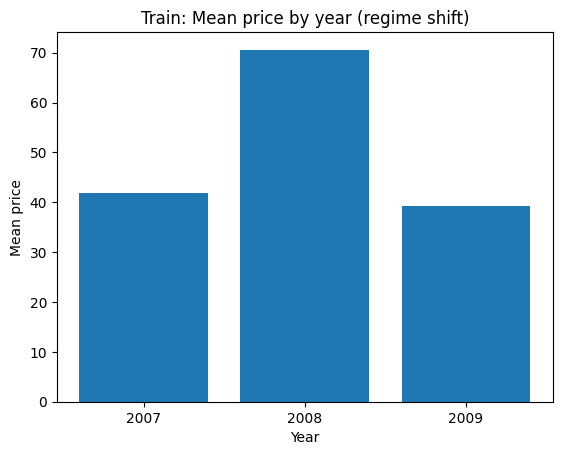

In [3]:
print("Years:", sorted(train["year"].unique()))
print("Missing prices:", int(train["price"].isna().sum()))
print("Any negative prices:", bool((train["price"] < 0).any()))
print("Min/Max price:", float(train["price"].min()), float(train["price"].max()))

yearly = train.groupby("year")["price"].agg(["mean","std","min","max"])
display(yearly)

plt.figure()
plt.bar(yearly.index.astype(str), yearly["mean"])
plt.title("Train: Mean price by year (regime shift)")
plt.xlabel("Year"); plt.ylabel("Mean price")
plt.show()

## 2) Intraday seasonality (day opportunities + volatile evening peak)

,mean,std
hour,,
1,38.838120,21.884887
2,33.993558,16.453507
3,30.053896,15.947602
4,24.881168,14.585498
5,23.124434,14.436540
6,28.803768,15.899613
7,36.652199,20.775206
8,50.544790,28.969477
9,56.924398,30.775903


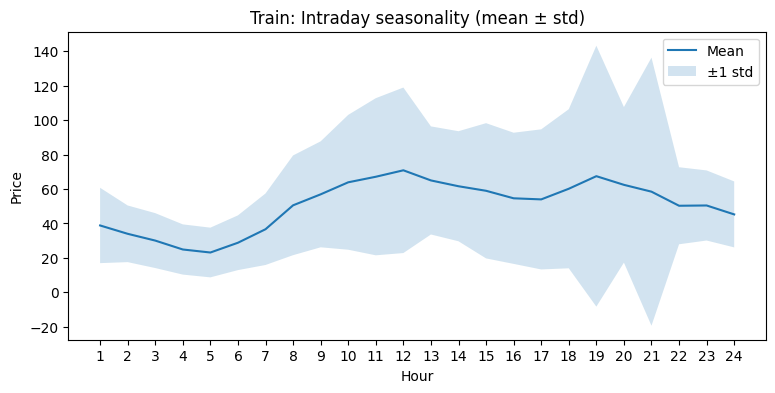

In [4]:
hourly = train.groupby("hour")["price"].agg(["mean","std"]).sort_index()
display(hourly)

plt.figure(figsize=(9,4))
plt.plot(hourly.index, hourly["mean"], label="Mean")
plt.fill_between(hourly.index, (hourly["mean"]-hourly["std"]).to_numpy(), (hourly["mean"]+hourly["std"]).to_numpy(), alpha=0.2, label="±1 std")
plt.title("Train: Intraday seasonality (mean ± std)")
plt.xlabel("Hour"); plt.ylabel("Price"); plt.xticks(range(1,25))
plt.legend()
plt.show()

## 3) Weekly pattern (weekend discount, midweek higher)

,mean,std
dow,,
0,53.064586,55.501468
1,57.229167,47.218849
2,55.373140,31.755275
3,56.382444,48.700572
4,53.305660,32.403174
5,44.441587,26.327677
6,34.295353,19.676196


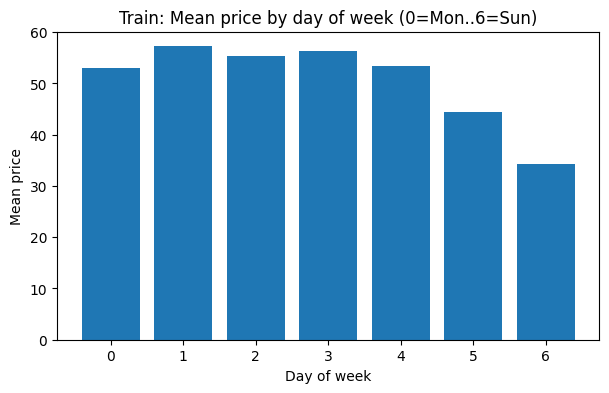

In [5]:
dow = train.groupby("dow")["price"].agg(["mean","std"]).sort_index()
display(dow)

plt.figure(figsize=(7,4))
plt.bar(dow.index, dow["mean"])
plt.title("Train: Mean price by day of week (0=Mon..6=Sun)")
plt.xlabel("Day of week"); plt.ylabel("Mean price"); plt.xticks(range(7))
plt.show()

## 4) Monthly seasonality (summer cheaper, autumn/winter higher)

,mean_price
month,
1,53.160354
2,47.572127
3,42.722746
4,46.349653
5,46.399727
6,45.453699
7,44.880367
8,40.299552
9,54.350134


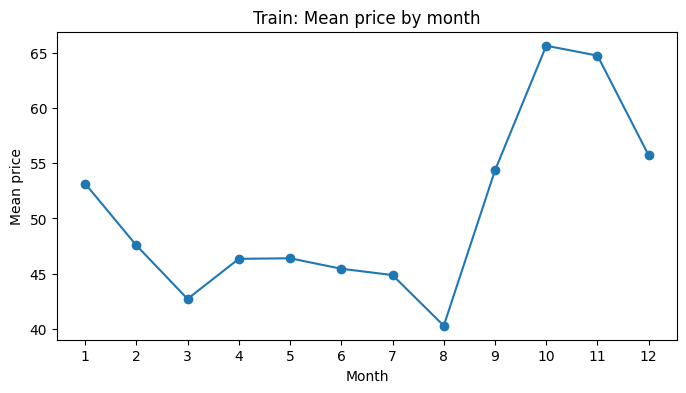

In [6]:
monthly = train.groupby("month")["price"].mean().sort_index()
display(monthly.to_frame("mean_price"))

plt.figure(figsize=(8,4))
plt.plot(monthly.index, monthly.values, marker="o")
plt.title("Train: Mean price by month")
plt.xlabel("Month"); plt.ylabel("Mean price"); plt.xticks(range(1,13))
plt.show()

## 5) Low volatility + rare extreme spikes (tail)

,quantile_price
0.500,43.0000
0.900,88.0100
0.950,104.6795
0.990,150.0000
0.999,400.0000


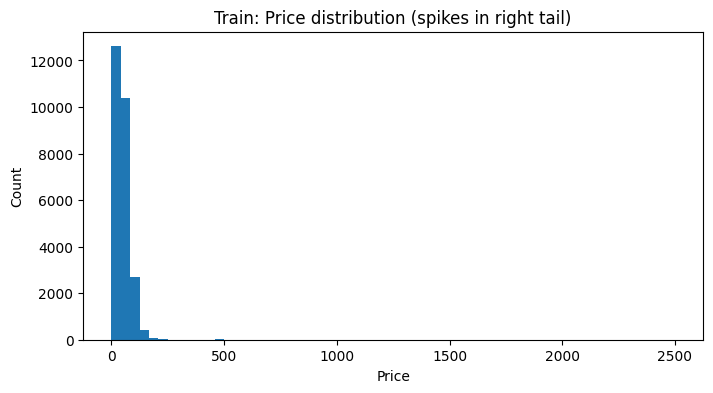

In [7]:
qs = train["price"].quantile([0.5, 0.9, 0.95, 0.99, 0.999])
display(qs.to_frame("quantile_price"))

plt.figure(figsize=(8,4))
plt.hist(train["price"].dropna(), bins=60)
plt.title("Train: Price distribution (spikes in right tail)")
plt.xlabel("Price"); plt.ylabel("Count")
plt.show()

## 6) Autocorrelation + daily repetition (lag-1 and lag-24)

Autocorr lag-1 : 0.7500536167404216
Autocorr lag-24: 0.5315055188021718


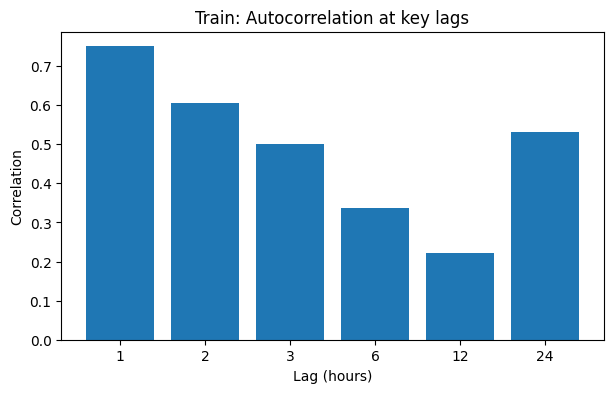

In [8]:
lag1 = train["price"].autocorr(lag=1)
lag24 = train["price"].autocorr(lag=24)
print("Autocorr lag-1 :", float(lag1))
print("Autocorr lag-24:", float(lag24))

lags = [1,2,3,6,12,24]
vals = [train["price"].autocorr(lag=l) for l in lags]

plt.figure(figsize=(7,4))
plt.bar([str(l) for l in lags], vals)
plt.title("Train: Autocorrelation at key lags")
plt.xlabel("Lag (hours)"); plt.ylabel("Correlation")
plt.show()

## 7) Mean reversion at extremes (spikes revert)

In [9]:
tmp = train[["price"]].copy()
tmp["next"] = tmp["price"].shift(-1)
tmp["delta"] = tmp["next"] - tmp["price"]

q95 = tmp["price"].quantile(0.95)
q05 = tmp["price"].quantile(0.05)

mean_next_change_high = tmp.loc[tmp["price"] >= q95, "delta"].mean()
mean_next_change_low  = tmp.loc[tmp["price"] <= q05, "delta"].mean()

print("Mean next-hour change when price in top 5%   :", float(mean_next_change_high))
print("Mean next-hour change when price in bottom 5%:", float(mean_next_change_low))
print("(Negative in top bucket ⇒ mean reversion after spikes.)")

Mean next-hour change when price in top 5%   : -6.758936170212766
Mean next-hour change when price in bottom 5%: 3.284621212121212
(Negative in top bucket ⇒ mean reversion after spikes.)
